In [25]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

from pathlib import Path
from pystackreg import StackReg
from skimage.transform import warp,AffineTransform
import cv2

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [27]:
#### ALL PARAMETERS DEFINED HERE ####
crop_size = 400
im_size = 1400
start = im_size//2-crop_size//2
stop = im_size//2+crop_size//2
# Data paths
data_path_signal = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\inference\N2V\Vim_fixed_Avg1-3_no_clipping")
data_path_obs = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\dump\rec\timelapses_gathered")

# Data parameters
upsamp = 2
DataNoiseLvl = 1 #"all"
clip = -3
registration = False

# Inference parameters
n_pred = 1 # number of images to predict
num_samples = 10 # number of samples used to compute MMSE estimate
tta = False

# Model loading
modelName = "Vim_fixed_mltplSNR_30nm_Noise1_GMM1N2V_Clip-3_5Lat_6Blocks_betaKL0.4_upsamp2random2addConvLayer_NoAugment_last_vae"
modelPath = Path("./Trained_model/model/") / (modelName + ".net")
# modelPath = Path("C:/Users/guillaume.minet/Documents/GitHub/HDN_tests/Trained_model/model/") / (modelName + ".net")

model = torch.load(modelPath)
model.mode_pred=True
model.eval()


# Saving path and options
save_idx = 2
data_name = str(data_path_signal).split("\\")[3]
save_folder = Path(r"E:\dl_monalisa\Data") / data_name / r"inference\HDN\upsamp" / (modelName + f"_{save_idx}")

overwrite = True
save_samples = True
save_mmse = True
save_std = False
save_var = False

if not os.path.exists(save_folder):
    os.makedirs(save_folder)
else:
    assert overwrite == True, "Saving folder already exists. Set overwrite = True to enable overwriting inference folder"

In [28]:
# Load data

##### Load data ####

signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

if isinstance(DataNoiseLvl,list) or DataNoiseLvl == "all":
    mltplNoise = True
else:
    mltplNoise = False
    nNoise = 1

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    im_signal = imread(data_path_signal / file_signal)[0]
    
    # noise level selection
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        try:
            im_obs = imread(data_path_obs / file_obs)[DataNoiseLvl]
        except IndexError:
            continue

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if DataNoiseLvl == "all":
            print("Registration not available for all noise level yet")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

    if i+1 >= n_pred:
        print(f"Stop loading file at file {i} because reached n_pred {n_pred}")
        break

# Stack to numpy array
signal = np.stack(signal)
observation = np.stack(observation)

# Adjust array dimension if necessary
if mltplNoise:
    nNoise = observation.shape[1]
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)

# square crop (like in training)
if signal.shape[-1] != signal.shape[-2]:
    print("Cropping to square")
    a = min(signal.shape[-1],signal.shape[-2])
    signal = signal [...,0:a,0:a]
    observation = observation [...,0:a,0:a]

print(np.mean(observation),np.std(observation))
# Normalization
signal = (signal - np.mean(observation))/np.std(observation) 
observation = (observation - np.mean(observation))/np.std(observation)
# data_mean = 26.67201805114746
# data_std = 55.58269500732422 
# signal = (signal - data_mean) * data_std
# observation = (observation - data_mean) * data_std

# Cropping
signal = signal[...,start:stop,start:stop]
observation = observation[...,start:stop,start:stop]

#optional downsampling
if upsamp>1:
    signal2 = []
    observation2 = []
    for im in observation:
        dwnsamp=im[::upsamp,::upsamp]
        # interp=cv2.resize(dwnsamp, None, fx=upsamp, fy=upsamp, interpolation= cv2.INTER_CUBIC)
        observation2.append(dwnsamp)
    observation = np.stack(observation2)
    # for im in signal:
    #     dwnsamp=im[::upsamp,::upsamp]
    #     interp=cv2.resize(dwnsamp, None, fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
    #     signal2.append(interp)
    # signal = np.stack(signal2)

print(f"\n\nConcatenated arrays and cropped:\tSignal: {signal.shape}\tObservation: {observation.shape}")




Found 25 files.

Signal img_and_denoised_00.tiff:	Observation rec_c01_rec_CAM.tiff:	 Shape: (1416, 1392)
Stop loading file at file 0 because reached n_pred 1
Cropping to square
26.34868 49.8916


Concatenated arrays and cropped:	Signal: (1, 400, 400)	Observation: (1, 200, 200)


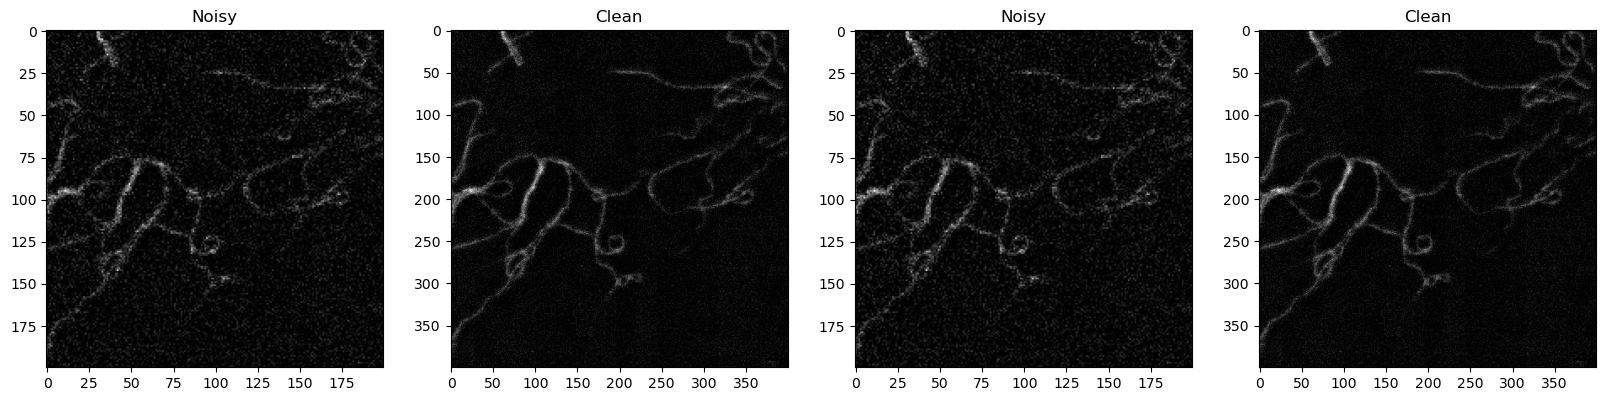

In [29]:
# Display examples

idxs = np.random.randint(0,observation.shape[0],2)

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(observation[idxs[0]],cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,2)
plt.imshow(signal[idxs[0]],cmap="gray")
plt.title("Clean")

plt.subplot(1,4,3)
plt.imshow(observation[idxs[1]],cmap="gray")
plt.title("Noisy")

plt.subplot(1,4,4)
plt.imshow(signal[idxs[1]],cmap="gray")
plt.title("Clean")

plt.show()

In [30]:
gaussian_noise_std = None
img_mmse_list = []
samples_list = []
# for i in range(observation.shape[0]):
for i in range (n_pred):
    for noise in range (nNoise):

        img_mmse, samples = boilerplate.predict(observation[i*nNoise+noise],num_samples,model,gaussian_noise_std,device,tta)
        img_mmse_list.append(img_mmse)
        samples_list.append(np.stack(samples))

        

100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


In [31]:
### saving solutions

for i in range(n_pred):
    if mltplNoise:
        summary = [signal[i*nNoise]]
        for noise in range(nNoise):
            obs = cv2.resize(observation[i*nNoise+noise],None,fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
            summary.append(obs)
            summary.append(img_mmse_list[i*nNoise+noise])
            samples = samples_list[i*nNoise+noise] 
            std = np.std(samples,axis=0)
            std_norm = std / img_mmse_list[i*nNoise+noise]
            var = np.var(samples,axis=0)
            var_norm = var / img_mmse_list[i*nNoise+noise]
            if save_samples:
                imsave(save_folder / f"samples_{i:02d}_Noise{noise}_{i:02d}.tif",samples)
            if save_std:
                imsave(save_folder / f"std_{i:02d}_Noise{noise}_{i:02d}.tif",std)
                imsave(save_folder / f"std_norm{i:02d}_Noise{noise}_{i:02d}.tif",std_norm)
            if save_var:
                imsave(save_folder / f"var_{i:02d}_Noise{noise}_{i:02d}.tif",var)
                imsave(save_folder / f"var_norm{i:02d}_Noise{noise}_{i:02d}.tif",var_norm)
        
        summary=np.stack(summary,axis=0)

        if save_mmse:
            if isinstance(DataNoiseLvl,list):
                noise_level_str = ''.join(str(DataNoiseLvl).split(', '))[1:-1]
            else:
                noise_level_str = DataNoiseLvl
            imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{noise_level_str}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})


    else:
        obs = cv2.resize(observation[i],None,fx=upsamp, fy=upsamp, interpolation= cv2.INTER_NEAREST)
        summary = np.stack([signal[i],obs,img_mmse_list[i]])
        # summary = np.stack([observation[i],img_mmse_list[i]])
        samples = samples_list[i]
        std = np.std(samples,axis=0)
        std_norm = std / img_mmse_list[i]
        var = np.var(samples,axis=0)
        var_norm = var / img_mmse_list[i]
        if save_mmse:
            imsave(save_folder / f"gt_inp_mmse{num_samples}_Noise{DataNoiseLvl}_{i:02d}.tif",summary,imagej=True,metadata={'axes':'TYX'})
        if save_samples:
            imsave(save_folder / f"samples_{i:02d}_Noise{DataNoiseLvl}_.tif",samples)
        if save_std:
            imsave(save_folder / f"std_{i:02d}_Noise{DataNoiseLvl}_.tif",std)
            imsave(save_folder / f"std_norm{i:02d}_Noise{DataNoiseLvl}_.tif",std_norm)
        if save_var:
            imsave(save_folder / f"var_{i:02d}_Noise{DataNoiseLvl}_.tif",var)
            imsave(save_folder / f"var_norm{i:02d}_Noise{DataNoiseLvl}_.tif",var_norm)

In [32]:
# i = 0
# samples = samples_list[i]
# mmse = img_mmse_list[i]
# psnrs = []
# range_psnr = np.max(observation[0])-np.min(observation[0])
# for sample in samples: 
#     psnr = utils.PSNR(sample, img_mmse, range_psnr)
#     psnrs.append(psnr)

In [33]:
# best = np.argmax(psnrs)
# worst = np.argmin(psnrs)
# print(best)
# print(worst)
# plt.figure(figsize=(20,20))
# plt.imshow(samples[best],cmap='gray')
# plt.show()
# plt.figure(figsize=(20,20))
# plt.imshow(samples[worst],cmap='gray')
# plt.show()